In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ctgan import CTGAN
from ctgan import load_demo
import data_describe as dd
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data = pd.read_csv('../data/S&P 500 Industrials 200-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data

,date,S&P 500,S&P 500 Industrials (Sector),S&P 500 Performance (%),S&P 500 Industrials (Sector) Performance (%),S&P 500 Industrials (Sector) Outperform/Underperform,overall,energy,commodities,communication,transportation,services,durable
1159,1997-12-02,971.68,210.110001,-4.745660,9.199104,OUTPERFORM,162.000,107.500,142.000,99.60,143.000,182.1,127.800
1160,1997-12-03,976.77,209.130005,-4.602057,8.419309,OUTPERFORM,162.000,107.500,142.000,99.60,143.000,182.1,127.800
1161,1997-12-04,973.10,208.500000,-5.490322,7.038353,OUTPERFORM,162.000,107.500,142.000,99.60,143.000,182.1,127.800
1162,1997-12-05,983.79,210.610001,-7.719799,4.205631,OUTPERFORM,162.000,107.500,142.000,99.60,143.000,182.1,127.800
1163,1997-12-08,982.37,210.490005,-5.787747,5.954898,OUTPERFORM,162.000,107.500,142.000,99.60,143.000,182.1,127.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7194,2021-11-24,4701.46,895.200012,19.548197,15.172333,UNDERPERFORM,280.126,263.553,210.452,76.33,250.105,348.1,126.416
7195,2021-11-26,4594.62,870.760010,16.437110,12.234479,UNDERPERFORM,280.126,263.553,210.452,76.33,250.105,348.1,126.416
7196,2021-11-29,4655.27,872.809998,19.324593,13.712283,UNDERPERFORM,280.126,263.553,210.452,76.33,250.105,348.1,126.416
7197,2021-11-30,4567.00,850.539978,17.908879,13.138321,UNDERPERFORM,280.126,263.553,210.452,76.33,250.105,348.1,126.416


## Using data after 2010

In [3]:
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2010]
data

,year,month,date,S&P 500,S&P 500 Industrials (Sector),S&P 500 Performance (%),S&P 500 Industrials (Sector) Performance (%),S&P 500 Industrials (Sector) Outperform/Underperform,overall,energy,commodities,communication,transportation,services,durable,dow
145,2010,1,2010-01-14,1148.46,257.549988,-2.941027,-7.292758,UNDERPERFORM,217.281,209.624,174.321,84.849,191.978,259.970,111.811,3
146,2010,2,2010-02-11,1078.47,242.679993,-9.326551,-13.630869,UNDERPERFORM,217.353,209.326,174.137,84.868,191.375,260.342,111.683,3
147,2010,3,2010-03-11,1150.24,262.059998,-8.476491,-12.669952,UNDERPERFORM,217.403,209.219,173.874,84.840,191.249,260.672,111.397,3
148,2010,4,2010-04-08,1186.44,276.230011,-7.551331,-11.277056,UNDERPERFORM,217.290,206.631,173.367,84.738,190.231,260.932,111.206,3
149,2010,5,2010-05-13,1157.44,277.670013,-12.792152,-13.303980,UNDERPERFORM,217.199,203.764,172.929,84.622,189.426,261.188,110.989,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,2021,7,2021-07-08,4320.82,861.239990,1.147999,3.484572,OUTPERFORM,273.092,242.958,201.975,76.056,236.783,342.831,120.078,3
284,2021,8,2021-08-12,4460.83,889.830017,7.276877,10.521416,OUTPERFORM,274.214,245.847,203.215,76.337,237.107,343.808,120.714,3
285,2021,9,2021-09-09,4493.28,863.659973,15.209058,15.223799,OUTPERFORM,276.590,255.010,206.035,76.407,241.826,345.648,122.650,3
286,2021,10,2021-10-14,4438.26,861.609985,8.483351,7.597683,UNDERPERFORM,278.524,261.257,208.467,76.317,246.749,346.911,124.413,3


In [4]:
original = data[['S&P 500 Industrials (Sector) Outperform/Underperform','month','overall','energy', 'commodities',\
                 'communication', 'transportation', 'services','durable']]

In [5]:
data.drop(columns=['date','S&P 500 Industrials (Sector) Outperform/Underperform','year'], inplace=True)
data.head()

,month,S&P 500,S&P 500 Industrials (Sector),S&P 500 Performance (%),S&P 500 Industrials (Sector) Performance (%),overall,energy,commodities,communication,transportation,services,durable,dow
145,1,1148.46,257.549988,-2.941027,-7.292758,217.281,209.624,174.321,84.849,191.978,259.970,111.811,3
146,2,1078.47,242.679993,-9.326551,-13.630869,217.353,209.326,174.137,84.868,191.375,260.342,111.683,3
147,3,1150.24,262.059998,-8.476491,-12.669952,217.403,209.219,173.874,84.840,191.249,260.672,111.397,3
148,4,1186.44,276.230011,-7.551331,-11.277056,217.290,206.631,173.367,84.738,190.231,260.932,111.206,3
149,5,1157.44,277.670013,-12.792152,-13.303980,217.199,203.764,172.929,84.622,189.426,261.188,110.989,3


In [6]:
original['Performance'] = np.where(original['S&P 500 Industrials (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','energy', 'commodities',\
                 'communication', 'transportation', 'services','durable']]

In [7]:
dd.data_summary(original)

,Info
Rows,143
Columns,9
Size in Memory,11.2 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,1,1,0.57,0.50,2,81
month,int64,0,0,1,6,12,6.46,3.43,12,12
overall,float64,0,0,217.20,238.033,280.13,241.91,14.66,141,2
energy,float64,0,0,176.40,218.54,263.55,221.44,21.49,143,1
commodities,float64,0,0,172.93,184.92,210.45,184.87,6.15,143,1
communication,float64,0,0,72.92,79.91,84.87,78.92,4.086,141,2
transportation,float64,0,0,188.78,209.96,250.10,208.81,11.62,143,1
services,float64,0,0,259.97,295.76,348.10,298.29,25.70,143,1
durable,float64,0,0,103.43,109.32,126.42,109.35,4.25,142,2


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

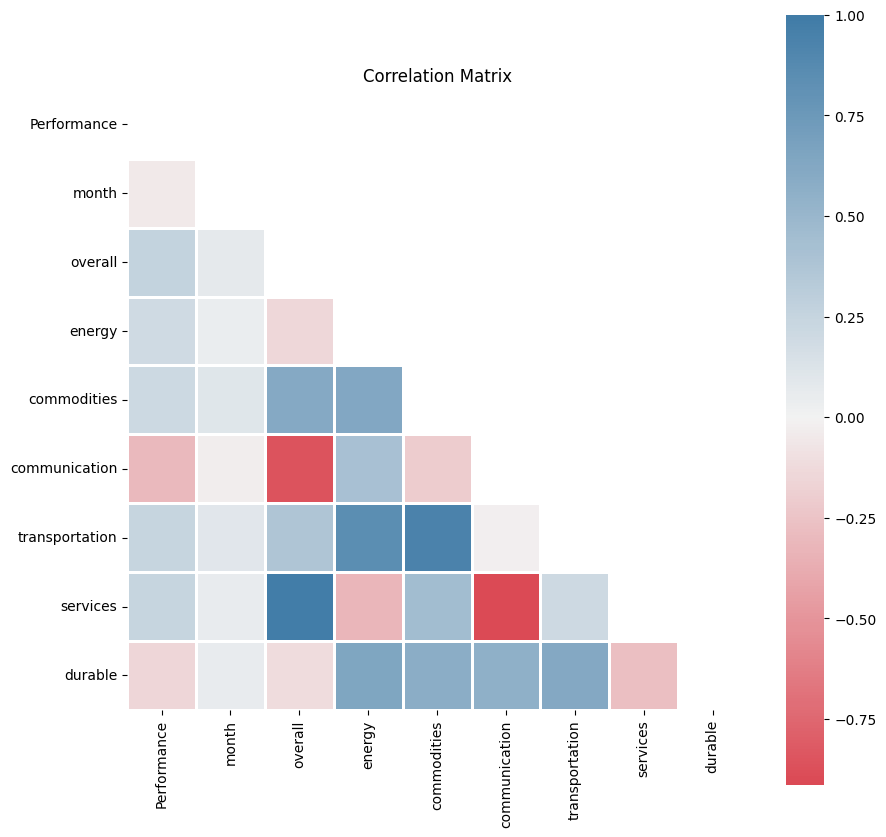

In [8]:
dd.correlation_matrix(original)

### Conditional GAN

In [9]:
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Industrials (Sector),S&P 500 Performance (%),S&P 500 Industrials (Sector) Performance (%),overall,energy,commodities,communication,transportation,services,durable,dow
0,5,4886.704468,798.971489,16.215142,12.082974,257.483501,219.259890,185.464065,74.122215,195.508274,323.221077,108.263822,3
1,4,1634.627021,322.000581,17.670414,10.197770,221.168875,205.563673,175.855672,79.443657,199.003577,265.786566,105.662326,3
2,2,965.539078,342.001583,7.818637,7.373793,213.405581,216.757619,174.036447,84.553920,192.445286,252.916828,112.780637,3
3,10,1431.289747,534.638266,-1.178049,12.900109,234.289225,213.030050,181.404167,81.350794,202.437113,268.828843,106.371633,3
4,10,3142.411084,756.715165,-13.300930,-18.988013,253.864410,201.281095,185.557125,73.234198,204.756677,318.495000,102.309777,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,10,1294.273715,330.928276,-10.522991,-16.979413,221.789902,246.017899,179.913056,83.422105,211.687249,265.056723,112.914216,3
9996,2,1708.644660,327.303055,8.132028,-9.360359,227.575908,243.613042,182.990212,84.398497,211.187316,278.876278,113.364660,3
9997,11,1857.749519,375.015703,-14.043841,-19.967586,234.362586,245.818833,189.892839,84.225851,220.851507,281.127575,112.342491,3
9998,10,4790.102540,994.348405,7.810518,16.142416,277.274102,254.295576,215.111548,75.570001,251.900317,358.866250,123.883949,3


In [10]:
samples['Performance'] = np.where(samples['S&P 500 Industrials (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)

In [11]:
samples = samples[['Performance','month', 'overall','energy', 'commodities',\
                 'communication', 'transportation', 'services','durable']]
samples.head()

,Performance,month,overall,energy,commodities,communication,transportation,services,durable
0,0,5,257.483501,219.259890,185.464065,74.122215,195.508274,323.221077,108.263822
1,0,4,221.168875,205.563673,175.855672,79.443657,199.003577,265.786566,105.662326
2,0,2,213.405581,216.757619,174.036447,84.553920,192.445286,252.916828,112.780637
3,1,10,234.289225,213.030050,181.404167,81.350794,202.437113,268.828843,106.371633
4,0,10,253.864410,201.281095,185.557125,73.234198,204.756677,318.495000,102.309777


In [12]:
dd.data_summary(samples)

,Info
Rows,10000
Columns,9
Size in Memory,703.2 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,0,1,0.45,0.50,2,5514
month,int64,0,0,1,6,12,6.46,3.45,12,873
overall,float64,0,0,206.59,236.92,290.54,241.022,15.24,10000,1
energy,float64,0,0,170.27,217.67,284.095,221.65,20.77,10000,1
commodities,float64,0,0,171.057,185.51,220.85,185.48,7.024,10000,1
communication,float64,0,0,70.81,80.20,88.13,78.72,4.16,9998,2
transportation,float64,0,0,184.29,210.92,266.25,209.85,12.80,9999,2
services,float64,0,0,240.34,292.12,368.0028,298.19,27.33,9999,2
durable,float64,0,0,101.33,109.50,135.29,109.078,4.29,10000,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

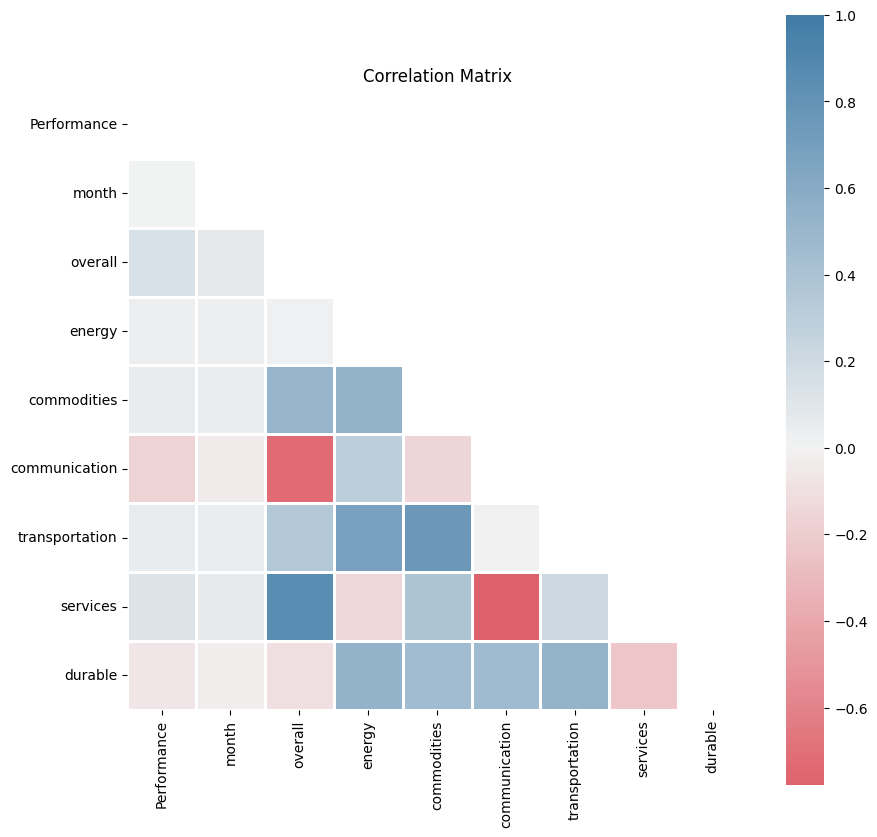

In [13]:
dd.correlation_matrix(samples)

In [14]:
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']

### SMOTE Oversampling

In [15]:
counter = Counter(y)
print(counter)
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({0: 5514, 1: 4486})
Counter({0: 5514, 1: 5514})


### Interaction Terms

In [16]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
X_poly

array([[  257.48350121,   219.25989047,   185.4640647 , ...,
        63192.39478923, 21166.47290121, 34993.14899765],
       [  221.16887528,   205.56367325,   175.85567243, ...,
        52892.4773488 , 21027.18090912, 28083.62688977],
       [  213.40558091,   216.75761944,   174.03644742, ...,
        48672.65125926, 21704.1020306 , 28524.12104138],
       ...,
       [  261.00684079,   250.30109373,   203.48765495, ...,
        79260.87460638, 30552.24455258, 41563.86943097],
       [  223.45167873,   252.59423043,   186.35615956, ...,
        56264.45923155, 24084.41017721, 29519.06363338],
       [  242.99905634,   211.34251671,   189.38295944, ...,
        63240.11913854, 23371.56958635, 32330.12139892]])

In [17]:
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X.shape

(11028, 29)

In [18]:
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
X_real.shape

(143, 29)

In [19]:
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)

### Training with CV

In [20]:
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.626875,0.61545,0.668328,0.640225,0.626768,0.624309,0.650828,0.637293,0.643357,0.714286,0.617284,0.662252
1,DecisionTreeClassifier,0.604381,0.60033,0.61754,0.60783,0.591222,0.59148,0.609791,0.600496,0.566434,0.630137,0.567901,0.597403
2,RandomForestClassifier,0.676113,0.669914,0.687735,0.677126,0.664853,0.67033,0.658747,0.664488,0.678322,0.79661,0.580247,0.671429
3,AdaBoostClassifier,0.654335,0.65001,0.669394,0.65943,0.66304,0.669367,0.654428,0.661813,0.727273,0.828125,0.654321,0.731034
4,GradientBoostingClassifier,0.667213,0.660501,0.688255,0.674023,0.670294,0.67341,0.670986,0.672196,0.734266,0.820896,0.679012,0.743243
5,ExtraTreesClassifier,0.692258,0.684872,0.703343,0.69165,0.683351,0.693114,0.666667,0.679633,0.671329,0.774194,0.592593,0.671329
6,BaggingClassifier,0.651539,0.668871,0.593605,0.627648,0.647806,0.675336,0.579554,0.623789,0.587413,0.689655,0.493827,0.57554
7,SVC,0.633753,0.624996,0.669025,0.646159,0.64309,0.640723,0.663787,0.652051,0.692308,0.803279,0.604938,0.690141
8,GaussianNB,0.576082,0.584802,0.525024,0.553265,0.581066,0.591121,0.546436,0.567901,0.643357,0.758621,0.54321,0.633094


## Using data after 2000

In [22]:
data = pd.read_csv('../data/S&P 500 Industrials 200-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2000]
data

,year,month,date,S&P 500,S&P 500 Industrials (Sector),S&P 500 Performance (%),S&P 500 Industrials (Sector) Performance (%),S&P 500 Industrials (Sector) Outperform/Underperform,overall,energy,commodities,communication,transportation,services,durable,dow
25,2000,1,2000-01-13,1449.68,271.299988,5.081257,-3.362543,UNDERPERFORM,170.000,118.800,147.600,94.700,150.000,192.500,125.100,3
26,2000,2,2000-02-10,1416.83,242.419998,5.594103,-14.484271,UNDERPERFORM,171.000,124.300,149.100,94.200,153.600,193.100,125.500,3
27,2000,3,2000-03-09,1401.69,237.440002,9.948543,-13.548150,UNDERPERFORM,170.900,120.900,148.500,93.800,152.100,193.500,125.400,3
28,2000,4,2000-04-13,1440.51,265.179993,4.861217,-6.111036,UNDERPERFORM,171.200,120.000,148.500,93.700,152.000,194.000,125.800,3
29,2000,5,2000-05-11,1407.81,269.410004,11.913923,-4.912993,UNDERPERFORM,172.200,126.800,149.600,92.600,155.000,194.900,125.500,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,2021,7,2021-07-08,4320.82,861.239990,1.147999,3.484572,OUTPERFORM,273.092,242.958,201.975,76.056,236.783,342.831,120.078,3
284,2021,8,2021-08-12,4460.83,889.830017,7.276877,10.521416,OUTPERFORM,274.214,245.847,203.215,76.337,237.107,343.808,120.714,3
285,2021,9,2021-09-09,4493.28,863.659973,15.209058,15.223799,OUTPERFORM,276.590,255.010,206.035,76.407,241.826,345.648,122.650,3
286,2021,10,2021-10-14,4438.26,861.609985,8.483351,7.597683,UNDERPERFORM,278.524,261.257,208.467,76.317,246.749,346.911,124.413,3


In [23]:
original = data[['S&P 500 Industrials (Sector) Outperform/Underperform','month','overall','energy', 'commodities',\
                 'communication', 'transportation', 'services','durable']]
data.drop(columns=['date','S&P 500 Industrials (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Industrials (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','energy', 'commodities',\
                 'communication', 'transportation', 'services','durable']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Industrials (Sector),S&P 500 Performance (%),S&P 500 Industrials (Sector) Performance (%),overall,energy,commodities,communication,transportation,services,durable,dow
0,9,1111.929015,278.815160,-8.248265,-10.755441,227.677314,237.512082,169.143465,80.680124,199.624253,268.219211,114.077342,3
1,1,1118.887903,479.283939,26.805684,0.132348,231.315361,216.007114,183.155117,84.228649,203.907660,256.580477,114.389615,3
2,7,1296.515645,289.336541,-3.700297,-7.147427,212.320256,230.175139,186.389965,84.570778,204.069699,257.930310,111.532146,3
3,7,895.378299,256.139090,7.568629,-4.928958,186.768211,96.868761,145.163860,96.794403,146.900179,213.205717,116.901189,3
4,8,1330.519366,253.681527,-7.837256,-10.637665,186.246513,189.044379,168.325328,84.526099,155.624435,218.241630,115.024296,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,12,1763.706123,332.683738,6.516985,-5.445167,232.306353,206.252567,184.123953,83.053011,197.018632,307.448942,105.435963,3
9996,11,3555.969035,792.846588,-0.593914,20.604389,275.046965,244.941908,201.887667,74.640601,230.085313,354.380336,107.427557,3
9997,6,1050.855259,227.077642,-10.524305,-8.077780,216.043227,178.575512,162.816538,85.597726,183.583511,265.464435,108.848285,3
9998,7,3069.658533,620.417613,-10.230939,-5.575214,239.524776,225.524246,181.196306,75.714198,208.451259,323.765197,108.545067,3


In [24]:
samples['Performance'] = np.where(samples['S&P 500 Industrials (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month', 'overall','energy', 'commodities',\
                 'communication', 'transportation', 'services','durable']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.566892,0.565506,0.576769,0.570785,0.567662,0.574846,0.569137,0.571977,0.448669,0.446809,0.484615,0.464945
1,DecisionTreeClassifier,0.538005,0.536787,0.546147,0.541031,0.555254,0.562021,0.560733,0.561377,0.520913,0.515152,0.523077,0.519084
2,RandomForestClassifier,0.598889,0.597865,0.595195,0.595786,0.588988,0.595256,0.594347,0.594801,0.43346,0.428571,0.438462,0.43346
3,AdaBoostClassifier,0.588604,0.591537,0.574255,0.582586,0.606049,0.614902,0.59893,0.606811,0.536122,0.529851,0.546154,0.537879
4,GradientBoostingClassifier,0.60169,0.602901,0.596359,0.59943,0.604498,0.60824,0.620321,0.614221,0.577947,0.567376,0.615385,0.590406
5,ExtraTreesClassifier,0.604123,0.602881,0.600813,0.6009,0.593253,0.601721,0.587471,0.594511,0.48289,0.47619,0.461538,0.46875
6,BaggingClassifier,0.578523,0.592465,0.497476,0.540046,0.56805,0.587444,0.500382,0.540429,0.562738,0.571429,0.461538,0.510638
7,SVC,0.582593,0.577402,0.618074,0.596852,0.590539,0.590164,0.632544,0.610619,0.562738,0.546584,0.676923,0.604811
8,GaussianNB,0.558551,0.550844,0.635718,0.590165,0.564948,0.562292,0.644767,0.600712,0.60076,0.578616,0.707692,0.636678


## Using all data (Best Model)

In [25]:
data = pd.read_csv('../data/S&P 500 Industrials 200-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data

,year,month,date,S&P 500,S&P 500 Industrials (Sector),S&P 500 Performance (%),S&P 500 Industrials (Sector) Performance (%),S&P 500 Industrials (Sector) Outperform/Underperform,overall,energy,commodities,communication,transportation,services,durable,dow
0,1997,12,1997-12-11,954.94,205.309998,-8.968370,2.639604,OUTPERFORM,162.000,107.500,142.000,99.600,143.000,182.100,127.800,3
1,1998,1,1998-01-15,950.73,203.119995,-13.465372,-4.238370,OUTPERFORM,162.000,105.100,141.800,99.200,142.400,182.300,127.900,3
2,1998,2,1998-02-12,1024.14,220.029999,-14.105994,-1.982358,OUTPERFORM,162.000,103.300,141.400,99.300,141.500,182.800,127.700,3
3,1998,3,1998-03-12,1069.92,227.740005,-12.750047,1.574416,OUTPERFORM,162.200,102.400,141.300,99.300,140.900,183.300,127.800,3
4,1998,4,1998-04-09,1110.67,235.630005,-11.310299,4.076860,OUTPERFORM,162.600,103.200,141.700,99.400,141.200,183.700,127.500,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,2021,7,2021-07-08,4320.82,861.239990,1.147999,3.484572,OUTPERFORM,273.092,242.958,201.975,76.056,236.783,342.831,120.078,3
284,2021,8,2021-08-12,4460.83,889.830017,7.276877,10.521416,OUTPERFORM,274.214,245.847,203.215,76.337,237.107,343.808,120.714,3
285,2021,9,2021-09-09,4493.28,863.659973,15.209058,15.223799,OUTPERFORM,276.590,255.010,206.035,76.407,241.826,345.648,122.650,3
286,2021,10,2021-10-14,4438.26,861.609985,8.483351,7.597683,UNDERPERFORM,278.524,261.257,208.467,76.317,246.749,346.911,124.413,3


In [26]:
original = data[['S&P 500 Industrials (Sector) Outperform/Underperform','month','overall','energy', 'commodities',\
                 'communication', 'transportation', 'services','durable']]
data.drop(columns=['date','S&P 500 Industrials (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Industrials (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','energy', 'commodities',\
                 'communication', 'transportation', 'services','durable']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Industrials (Sector),S&P 500 Performance (%),S&P 500 Industrials (Sector) Performance (%),overall,energy,commodities,communication,transportation,services,durable,dow
0,3,1076.389214,150.974038,-12.309650,-22.912795,173.699398,189.189561,159.523254,94.650554,143.657801,254.718506,124.164140,3
1,8,1071.762736,187.010235,-9.281357,-15.411554,237.745387,222.600039,177.750504,84.053197,212.007639,251.014971,115.534677,3
2,10,1773.478303,649.406507,-11.701283,-17.837269,273.859109,240.949816,192.875597,75.208453,210.617504,345.791344,104.161892,3
3,4,1441.536106,305.119476,33.936579,-12.461104,212.369144,141.683792,175.388306,85.546243,154.922025,201.752439,115.334703,3
4,1,1442.888690,238.077538,-7.947126,-15.936452,177.430656,227.025636,152.190906,83.222011,208.941338,198.875203,114.118788,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,8,3459.464762,906.588697,-1.003116,1.898783,248.977527,249.101009,210.668554,74.253771,224.314174,325.941592,108.112487,3
9996,8,1149.441815,252.671544,-15.140598,-18.890487,166.974843,113.672510,145.269146,93.413780,144.456616,202.334631,114.476144,3
9997,4,2329.302100,610.235458,-4.268466,-12.166471,231.693264,216.489732,183.568257,74.688225,193.151748,317.236397,109.271879,3
9998,12,1044.739155,194.155158,-6.614288,-11.947475,171.009836,98.004559,144.990499,90.914814,157.544854,206.832497,122.790881,3


In [27]:
samples['Performance'] = np.where(samples['S&P 500 Industrials (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month', 'overall','energy', 'commodities',\
                 'communication', 'transportation', 'services','durable']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.749714,0.693885,0.892862,0.780595,0.735849,0.6874,0.875767,0.770234,0.572917,0.575,0.62585,0.599349
1,DecisionTreeClassifier,0.728518,0.709462,0.772921,0.739491,0.715947,0.706506,0.749489,0.727363,0.569444,0.605505,0.44898,0.515625
2,RandomForestClassifier,0.852597,0.827746,0.890539,0.857203,0.821401,0.809291,0.846115,0.827293,0.524306,0.556818,0.333333,0.417021
3,AdaBoostClassifier,0.649738,0.657594,0.622989,0.639437,0.65159,0.664324,0.628323,0.645822,0.604167,0.670103,0.442177,0.532787
4,GradientBoostingClassifier,0.678044,0.684797,0.658402,0.670921,0.684415,0.694342,0.671268,0.68261,0.579861,0.63,0.428571,0.510121
5,ExtraTreesClassifier,0.881354,0.858583,0.913026,0.884439,0.854743,0.839338,0.881391,0.85985,0.559028,0.628205,0.333333,0.435556
6,BaggingClassifier,0.802709,0.805249,0.797483,0.800415,0.761954,0.778076,0.740286,0.758711,0.513889,0.535354,0.360544,0.430894
7,SVC,0.651932,0.652145,0.651419,0.65149,0.651331,0.659653,0.641104,0.650246,0.638889,0.690265,0.530612,0.6
8,GaussianNB,0.61574,0.597296,0.71048,0.648934,0.616955,0.601892,0.715746,0.6539,0.59375,0.6,0.612245,0.606061


### Voting Classifier

In [28]:
et_clf = ExtraTreesClassifier(random_state=random_state)
bag_clf = BaggingClassifier(random_state=random_state)
rf_clf = RandomForestClassifier(random_state=random_state)
classifiers = [('RF', rf_clf), \
               ('ET', et_clf),\
              ('Bagging', bag_clf)]

vc = VotingClassifier(estimators = classifiers, voting = 'soft')     
vc.fit(x_train, y_train)
y_pred = vc.predict(x_test)
vc_res = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F-1 Score'])
vc_res.loc[0, 'Accuracy'] = accuracy_score(y_test, y_pred)
vc_res.loc[0, 'Precision'] = precision_score(y_test, y_pred)
vc_res.loc[0, 'Recall'] = recall_score(y_test, y_pred)
vc_res.loc[0, 'F-1 Score'] = f1_score(y_test, y_pred)
vc_res

,Accuracy,Precision,Recall,F-1 Score
0,0.830964,0.813584,0.863497,0.837798
